<a href="https://colab.research.google.com/github/dimi-fn/Spotify-Songs/blob/master/Spotify_Songs_Genres_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries for data analysis and manipulation
import pandas as pd
import numpy as np

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To ignore potential useless warnings from Scipy (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# to make this notebook's output identical at every run
np.random.seed(42)

In [3]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

> Inserting the dataset for regression and classification (the split between train and test set is already done).

In [5]:
downloaded = drive.CreateFile({'id':'1faxDrc-DqcciP0PghJbJJts9CRa0bL82'}) 
downloaded.GetContentFile('CS98XClassificationTest.csv') 
classification_test = pd.read_csv('CS98XClassificationTest.csv') 

downloaded = drive.CreateFile({'id':'1TQq8nRRdowS_aULA1SKviqAisw9NWIUd'}) 
downloaded.GetContentFile('CS98XClassificationTrain.csv') 
classification_train = pd.read_csv('CS98XClassificationTrain.csv') 

downloaded = drive.CreateFile({'id':'1tmBD1ct5ig0UF7iIPmcM0MqDwJpYvtpo'}) 
downloaded.GetContentFile('CS98XRegressionTest.csv') 
regression_test = pd.read_csv('CS98XRegressionTest.csv') 

downloaded = drive.CreateFile({'id':'1Zgg12bV-xXozSRI5Kj4631gwbBe2K8By'}) 
downloaded.GetContentFile('CS98XRegressionTrain.csv') 
regression_train = pd.read_csv('CS98XRegressionTrain.csv') 

# Classification Task

> Supervised regression, which was built in the previous notebook, is for predicting numeric values. Now we are proceeding to supervised classification which is suitable for predicting classes. In this case we want to predict the 'top genre' class:

In [6]:
classification_train.shape

(453, 15)

In [7]:
classification_test.shape

(113, 14)

In [8]:
classification_train.head(1)

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards


In [9]:
classification_test.head(1)

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,454,Pump It,The Black Eyed Peas,2005,154,93,65,-3,75,74,213,1,18,72


In [10]:
classification_train['top genre'].nunique()

86

> More specifically, it is about a multiclass classification problem (86 unique top genres in the test data).

- Stochastic Gradient Descend (SGD) classifiers, Random Forest classifiers and Naive Bayes classifiers are able to proceed to multiclass classification.


- Logistic Regression and Support Vector Machine (SVM) classifiers are suitable as binary classifiers. However, there are ways we can implement multiclass classification with multiple binary classifiers: either with One versus Rest (OvR) or with One versus One (OvO). In the case of OvR, we should train 86 binary classifiers, one for each genre out of the 86. With OvO, we would train a binary classifier for every par of genres, e.g. one to distinguish 'adult standards' from 'album rock' and so on. In every case, Scikit-Learn can understand when you try to use a binary classification algorithm for multiclass classification, and automatically it runs OvR or OvO.


In [11]:
# counting the aggregated number of 'top genre' in descending order
# we notice, e.g., that 'adult standards' is the most popular in terms of 'top genre' with 68 songs (out of 453) belonging to this category
classification_train['top genre'].value_counts().sort_values(ascending=False).head()

adult standards       68
album rock            66
dance pop             61
brill building pop    16
glam rock             16
Name: top genre, dtype: int64

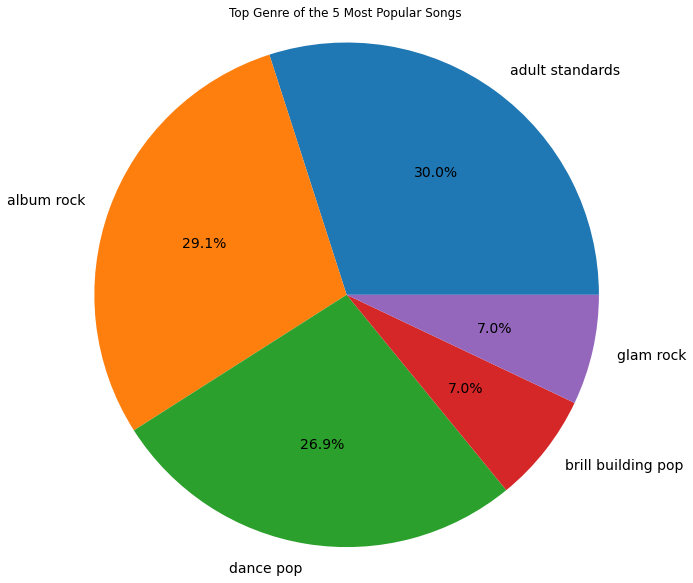

In [12]:
classification_train_max_genre=classification_train['top genre'].value_counts(ascending=False).head(5)

# Find percent of each genre
classification_train_genre = classification_train_max_genre / len(classification_train_max_genre)
sizes =classification_train_genre.values.tolist()
labels = classification_train_genre.index.values.tolist()

# Pie chart for genre
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 14})
ax1.axis('equal')
plt.title('Top Genre of the 5 Most Popular Songs')
plt.show()


### Preparing the data for machine learning algorithms

> Data cleaning:

In [13]:
classification_train.isnull().any()

Id           False
title        False
artist       False
year         False
bpm          False
nrgy         False
dnce         False
dB           False
live         False
val          False
dur          False
acous        False
spch         False
pop          False
top genre     True
dtype: bool

In [14]:
classification_test.isnull().any()

Id        False
title     False
artist    False
year      False
bpm       False
nrgy      False
dnce      False
dB        False
live      False
val       False
dur       False
acous     False
spch      False
pop       False
dtype: bool

> Hence, there are missing values in 'top genre' in train data.

> As in regression, we are replacing the missing values with the most frequent top genre which is adult standards:

In [15]:
classification_train['top genre'].fillna(value='adult standards', inplace=True)

In [16]:
classification_train.isnull().sum().any()

False

In [17]:
classification_test.isnull().sum().any()

False

In [18]:
train_predictors= classification_train[['nrgy', 'dnce', 'dB', 'dur', 'pop']]
train_target= classification_train[['top genre']].copy()

In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [20]:
train_predictors_num= train_predictors

In [21]:
imputer.fit(train_predictors_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [22]:
imputer.statistics_

array([ 63.,  61.,  -8., 223.,  63.])

In [23]:
train_predictors_num.median().values

array([ 63.,  61.,  -8., 223.,  63.])

In [24]:
W = imputer.transform(train_predictors_num)

In [25]:
train_predictors_tr = pd.DataFrame(W, columns=train_predictors_num.columns,
                          index=train_predictors.index)

> As in, regression, building a pipeline using ColumnTransformer. The difference here is that we are not passing any categorical features:

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [27]:
train_predictors

,nrgy,dnce,dB,dur,pop
0,31,45,-8,150,44
1,44,53,-8,139,37
2,36,63,-9,245,77
3,28,47,-16,232,67
4,47,56,-8,193,63
...,...,...,...,...,...
448,22,18,-17,214,45
449,81,53,-13,147,50
450,55,73,-8,289,77
451,87,64,-5,191,62


In [28]:
numeric_features = list(train_predictors_num)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])



numerical_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

train_predictors_final= numerical_pipeline.fit_transform(train_predictors)

In [29]:
train_predictors_final

array([[-1.31062408, -0.9416684 ,  0.23414198, -1.19745997, -1.24442005],
       [-0.72453059, -0.42445011,  0.23414198, -1.37014455, -1.76466474],
       [-1.08520351,  0.22207275, -0.04571638,  0.29390687,  1.20816206],
       ...,
       [-0.22860532,  0.86859562,  0.23414198,  0.9846452 ,  1.20816206],
       [ 1.21408635,  0.28672504,  1.07371704, -0.55381744,  0.09335201],
       [ 0.58290874,  0.54533418,  0.23414198,  0.85905641, -0.12961   ]])

In [30]:
len(train_target)

453

### Sychronising the test set with the train set

In [31]:
test_predictors=classification_test[['nrgy', 'dnce', 'dB', 'dur', 'pop']] # test predictors

In [32]:
test_predictors.isnull().sum().any()

False

> As in regression's pipeline, now in the test set we use 'transform' instead of 'fit_transform', so that we can transform the test data with the same fitted scaler (as in regression, but here without carrying any categorical features):

In [33]:
test_predictors_final= numerical_pipeline.transform(test_predictors)

In [34]:
train_predictors_final.shape

(453, 5)

In [35]:
train_target.shape

(453, 1)

In [36]:
test_predictors_final.shape


(113, 5)

### RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder 

In [38]:
#Using the random forest classifier for the prediction 
classifier=RandomForestClassifier() 
classifier=classifier.fit(train_predictors_final,train_target.values.ravel())
predicted=classifier.predict(test_predictors_final) 
  

In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.30463576, 0.30463576, 0.25827815])

In [40]:
classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': predicted})
classification_results 
#classification_results.to_csv('cc.csv', index = False)
# classification accuracy= 37.5%

,Id,top genre
0,454,dance pop
1,455,album rock
2,456,adult standards
3,457,dance pop
4,458,brill building pop
...,...,...
108,563,dance pop
109,564,dance pop
110,565,dance pop
111,566,album rock


In [41]:
for_classifier=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42) 
for_classifier=for_classifier.fit(train_predictors_final,train_target.values.ravel())
predicted_forest=for_classifier.predict(test_predictors_final) 
  

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(for_classifier, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.29801325, 0.33112583, 0.31788079])

In [43]:
classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': predicted_forest})
#classification_results 
#classification_results.to_csv('ff.csv', index = False)
#classification accuracy= 35.71%

> Feature importances by the RandomForestClassifier:

In [44]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(train_predictors_final,train_target.values.ravel())
for name, score in zip(train_predictors, rnd_clf.feature_importances_):
    print(name, score)

nrgy 0.22090559267524312
dnce 0.19669153293294092
dB 0.1515738048596474
dur 0.23481086584726624
pop 0.19601820368490233


### Stochastic Gradient Descent (SGD) Classifier

In [45]:
from sklearn.linear_model import SGDClassifier
sgd_clf= SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(train_predictors_final, train_target.values.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

> Evaluating the SGDClassifier:

>> Using k-fold-cross validation with k=3 (splitting the test set into 3 folds), we make predictions and evaluate each fold using a model trained on the remaining folds:


In [46]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.13907285, 0.1192053 , 0.14569536])

> The above results show accuracy between 11% and 14% as ratio of correct predictions on all cross-validation folds.

### Support Vector Machine (SVM) Classifier:

In [47]:
from sklearn.svm import SVC
svm_clf= SVC(gamma='auto', random_state=42)
svm_clf.fit(train_predictors_final,train_target.values.ravel())


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [48]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

# more promissing than SGDClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.33774834, 0.33774834, 0.33774834])

In [49]:
svm_clf_predicted= svm_clf.predict(test_predictors_final)

In [50]:
classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': svm_clf_predicted})
#classification_results 
#classification_results.to_csv('dd.csv', index = False)
# classification accuracy= 35.71%

> Increasing regularisation parameter C. The default used above is 1. 

In [51]:
svm_clf= SVC(gamma='auto', random_state=42,C=2)
svm_clf.fit(train_predictors_final,train_target.values.ravel())

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [52]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.35099338, 0.33112583, 0.35099338])

> As we can see, indeed, it performs better.

In [53]:
svm_clf_predicted= svm_clf.predict(test_predictors_final)

In [54]:
classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': svm_clf_predicted})
#classification_results 
#classification_results.to_csv('ee.csv', index = False)
# classification accuracy= 37.5 = RandomForestClassifier accuracy

### KNeighborsClassifier using GridSearchCV

> Using grid search on the weights and n_neighbours hyperparameters:

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

> ******************************************************************************************************************
> Please, for the below codes using GridSearchCV, delete the comments so that the cells can be executed. They are left in comments for readibility because the output covers a lot of pages in the pdf file.
> ******************************************************************************************************************

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

'''
param_grid = [{'weights': ["uniform", "distance"],'n_neighbors': list(range(1,100))}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(train_predictors_final,train_target.values.ravel())

'''


'\nparam_grid = [{\'weights\': ["uniform", "distance"],\'n_neighbors\': list(range(1,100))}]\n\nknn_clf = KNeighborsClassifier()\ngrid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)\ngrid_search.fit(train_predictors_final,train_target.values.ravel())\n\n'

In [57]:
# grid_search.best_params_

In [58]:
# grid_search.best_score_

In [59]:
'''
from sklearn.model_selection import cross_val_score
cross_val_score(grid_search, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

# more promissing than SGDClassifier
'''

"\nfrom sklearn.model_selection import cross_val_score\ncross_val_score(grid_search, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')\n\n# more promissing than SGDClassifier\n"

In [60]:
# grid_predicted= grid_search.predict(test_predictors_final)

In [61]:
#classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': grid_predicted})
#classification_results 
#classification_results.to_csv('ww.csv', index = False)
#classification accuracy=  32.14%

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression(solver='lbfgs', random_state=42)
log_reg.fit(train_predictors_final,train_target.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
predictions_logistic= log_reg.predict(test_predictors_final)

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(log_reg, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.32450331, 0.30463576, 0.31788079])

> Using solver='linear', which based on the documentation, is more suitable for small datasets:

In [65]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(train_predictors_final,train_target.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
predictions_logistic= log_reg.predict(test_predictors_final)

In [67]:
from sklearn.model_selection import cross_val_score
cross_val_score(log_reg, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.31788079, 0.33112583, 0.31788079])

In [68]:
#classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': predictions_logistic})
#classification_results 
#classification_results.to_csv('ll.csv', index = False)
#classification accuracy=  37.5

### Softmax Regression

> Just like logistic regression classifier, the Softmax Regression Classifier predicts the class with the highest estimated probability (which is the class with the highest score).

> Softmax is suitable for multiclass classification, as in our case (however, not for multioutput one):

In [69]:
softmax= LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10, random_state=42, max_iter=1000)
softmax.fit(train_predictors_final,train_target.values.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
from sklearn.model_selection import cross_val_score
cross_val_score(softmax, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.29139073, 0.27152318, 0.31788079])

> Trying to decrease the hyperparameter C to 0.3, which here is the inverse of regularization strength (default=1):

In [71]:
softmax= LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.3, random_state=42, max_iter=1000)
softmax.fit(train_predictors_final,train_target.values.ravel())

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
from sklearn.model_selection import cross_val_score
cross_val_score(softmax, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.33112583, 0.33112583, 0.32450331])

> Indeed, it gave greater accuracy.

In [73]:
predictions_softmax= softmax.predict(test_predictors_final)

In [74]:
#classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': predictions_softmax})
#classification_results 
#classification_results.to_csv('ss.csv', index = False)
#classification accuracy=  37.5% = RandomForestClassifier=SVMClassifier=Logistic regr. Classifier

### DecisionTreeClassifier

In [75]:
from sklearn.tree import DecisionTreeClassifier
tree_clf= DecisionTreeClassifier(max_depth=2,random_state=42)
tree_clf.fit(train_predictors_final, train_target.values.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [76]:
tree_predictions= tree_clf.predict(test_predictors_final)

In [77]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree_clf, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.29801325, 0.25165563, 0.29139073])

> The DecisionTreeClassifier is overfitting the test data (accuracy=23.21%) since it is performing better in training (25<accuracy<29%).

In [78]:
#classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': tree_predictions})
#classification_results 
#classification_results.to_csv('tt.csv', index = False)
#classification accuracy=  23.21%

In [79]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(train_predictors_final, train_target.values.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    3.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [80]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [81]:
tree_predictions= grid_search_cv.predict(test_predictors_final)

In [82]:
from sklearn.model_selection import cross_val_score
cross_val_score(grid_search_cv, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    2.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    2.3s finished


array([0.28476821, 0.2781457 , 0.29801325])

> Even using the best estimator using grid search, the results for the decision tree classifier do not seem sarisfactory.
>> Modification of SVM:

> We noticed that increasing the C=2 (instead of the default=1), this model performs a little better in this case in the train data. However, in test set the score is the same as with the previous SVClassifier:

In [83]:
svm_clf_kernel= SVC(C=2, random_state=42)
svm_clf_kernel.fit(train_predictors_final, train_target.values.ravel())

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [84]:
svm_clf_kernel_predictions= svm_clf_kernel.predict(test_predictors_final)

In [85]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf_kernel, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.35099338, 0.33112583, 0.35099338])

In [86]:
#classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': svm_clf_kernel_predictions})
#classification_results 
#classification_results.to_csv('kr.csv', index = False)
#classification accuracy=  37.5%, same as the previous best models

In [87]:
from sklearn.ensemble import VotingClassifier
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(train_predictors_final, train_target.values.ravel())

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [88]:
voting_predictions= voting_clf.predict(test_predictors_final)

In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(voting_clf, train_predictors_final, train_target.values.ravel(), cv=3, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


array([0.31125828, 0.34437086, 0.31125828])

In [90]:
classification_results= pd.DataFrame({'Id': classification_test['Id'], 'top genre': voting_predictions})
#classification_results 
#classification_results.to_csv('vv.csv', index = False)
#classification accuracy=   37.5%, same as the previous best models

### Reflection on Classification:

> We had several models producing approximately the same accuracy here. Specifically, Random Forest Classifier, SVMClassifier, Logistic Regression Softmax Classifier and Voting Classifier gave approximately 37.5% classification accuracy.
One important point here is that Voting Classifier, against expectations, did not give better results. Although, theoritically, it should take the most accurate resutls from every classifier algorithm and produce higher accuracy overall, this did not happen. Again as in regression, this is probably due to the limited number of samples of features in the dataset.